In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from gp_oed_surrogate import create_gp, create_derivative_gp

In [3]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

In [4]:
# Peak function (see: https://mathworks.com/help/matlab/ref/peaks.html)
def generate_data(x, y):
    first_term = 3*(1-x)**2*jnp.exp(-x**2-(y+1)**2)
    second_term = -10*(x/5 - x**3 - y**5)*jnp.exp(-x**2-y**2)
    third_term = -1/3*jnp.exp(-(x+1)**2-y**2)
    return first_term + second_term + third_term

In [22]:
def plot_contours(x, y, z, num_pts):
    # Reshape inputs:
    x, y, z = x.reshape(num_pts, num_pts), y.reshape(num_pts, num_pts), z.reshape(num_pts, num_pts)
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(x, y, z, cmap='viridis')
    fig.colorbar(contour_fig)
    plt.plot(x, y, 'x', color='black', markersize=0.5)
    fig.patch.set_facecolor('white')
    plt.show()

In [19]:
# Generate test data:
generate_data_vmap = jax.vmap(generate_data, in_axes=[0,0])
train_pts = 10
x_train, y_train = jnp.linspace(-3, 3, train_pts), jnp.linspace(-3, 3, train_pts)
y_train, x_train = jnp.meshgrid(x_train, y_train)
z_train = generate_data_vmap(x_train.flatten(), y_train.flatten())
xy_train = jnp.vstack((x_train.flatten(),y_train.flatten())).T

# Define constraints:
constraints = {"length_0": {">": 10**-1, "<": 10**1}, 
               "length_1": {">": 10**-1, "<": 10**1}, 
               "const": {">": 10**-1, "<": 10**2}}
# Create GP surrogate:
gp = create_gp(kernel, xy_train, z_train, constraints)

161603.61
322.27716
322.15564
321.62006
318.7225
298.88177
193.63422
46837.895
177.90744
32824.895
416.61777
179.77797
177.11655
171.00253
167.31126
167.25317
169.49042
167.26845
167.23877
167.23877
167.20712
167.05197
167.23099
167.05197
169.7775
167.19876
167.20964
167.05197
167.05197
167.05197
167.05197
167.05197
167.05197
167.05197
167.05197
167.05197
167.05197
      fun: array(167.05197144)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.25355476, -10.99715424,  -8.46286774])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 37
      nit: 8
     njev: 37
   status: 0
  success: True
        x: array([91.9492323 ,  0.89263552,  1.10864839])
279318.25
322.27716
322.19147
321.82343
319.95563
307.61417
232.61234
13573.875
185.54813
187.46646
184.58582
1544.0782
197.16818
180.97885
326.81372
170.60678
167.13123
167.20438
166.98672
169.45444
166.93967
166.53186
169.94583
166.88727
166.53186
166.53186
166.53186
166.53186
166.53186
166.5

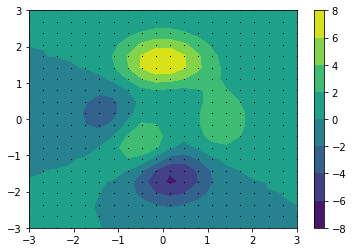

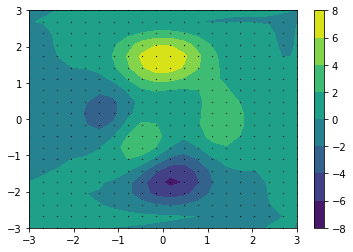

In [23]:
# Make predictions with GP:
pred_pts = 20
x_pred, y_pred = jnp.linspace(-3, 3, pred_pts), jnp.linspace(-3, 3, pred_pts)
y_pred, x_pred = jnp.meshgrid(x_pred, y_pred)
xy_pred = jnp.vstack((x_pred.flatten(),y_pred.flatten())).T
z_pred = gp.predict_mean(xy_pred)
# Plot GP surrogate surface and original data surface:
z_train = generate_data_vmap(x_train, y_train)
z_true = generate_data_vmap(xy_pred[:,0], xy_pred[:,1])
plot_contours(xy_pred[:,0], xy_pred[:,1], z_true, pred_pts)
plot_contours(xy_pred[:,0], xy_pred[:,1], z_pred, pred_pts)

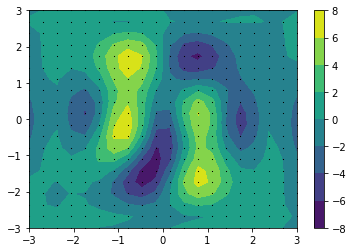

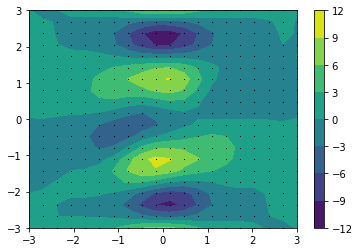

In [24]:
# Compute Jacobian of Gaussian process:
idx_2_diff = [([0,1], 1)]
gp_jac = create_derivative_gp(gp, idx_2_diff)

# Make predictions with Jacobian GP:
z_jac_pred = gp_jac.predict_grad_mean(xy_pred)
z_delx_pred, z_dely_pred = z_jac_pred[:,0], z_jac_pred[:,1]
plot_contours(xy_pred[:,0], xy_pred[:,1], z_delx_pred[:,0], pred_pts)
plot_contours(xy_pred[:,0], xy_pred[:,1], z_dely_pred[:,1], pred_pts)

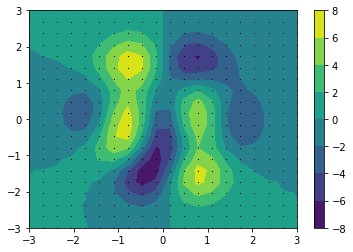

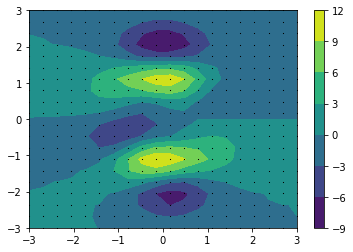

In [25]:
# Compare with actual Jacobian:
generate_data_delx_vmap = jax.vmap(jax.grad(generate_data, argnums=0), in_axes=[0,0])
z_delx_true = generate_data_delx_vmap(xy_pred[:,0], xy_pred[:,1])
plot_contours(xy_pred[:,0], xy_pred[:,1], z_delx_true, pred_pts)
generate_data_dely_vmap = jax.vmap(jax.grad(generate_data, argnums=1), in_axes=[0,0])
z_dely_true = generate_data_dely_vmap(xy_pred[:,0], xy_pred[:,1])
plot_contours(xy_pred[:,0], xy_pred[:,1], z_dely_true, pred_pts)

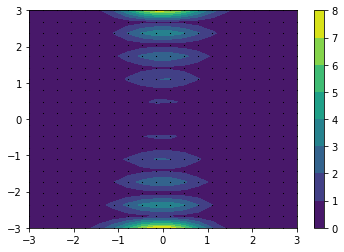

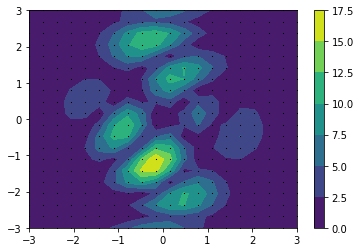

In [26]:
# Difference between prediction and Jacobian:
plot_contours(xy_pred[:,0], xy_pred[:,1], jnp.abs(z_dely_pred[:,1]-z_dely_true), pred_pts)
plot_contours(xy_pred[:,0], xy_pred[:,1], jnp.abs(z_delx_pred[:,1]-z_delx_true), pred_pts)

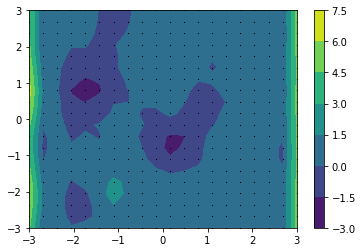

In [27]:
# Plot variance of predicted Jacobian:
z_grad_var = gp_jac.predict_grad_var(xy_pred)
#z_delx_var, z_dely_var = z_grad_var[:,0,0], z_grad_var[:,0,1]
z_delx_var = z_grad_var
plot_contours(xy_pred[:,0], xy_pred[:,1], z_delx_var, pred_pts)
#plot_contours(xy_pred[:,0], xy_pred[:,1], z_dely_var, pred_pts, save_name="peaks_dely_var.png")